## Reading data from case file

In [1]:
from openmdao.test_suite.components.sellar import SellarDerivativesGrouped
from openmdao.utils.assert_utils import assert_near_equal, assert_warning
import openmdao.api as om

import numpy as np

import pandas as pd
import panel as pn

In [2]:
prob = om.Problem()
model = prob.model = SellarDerivativesGrouped(nonlinear_solver=om.NonlinearBlockGS,
                                              linear_solver=om.ScipyKrylov)

prob.driver = om.ScipyOptimizeDriver(optimizer='SLSQP', tol=1e-9, disp=False)

model.add_design_var('z', lower=np.array([-10.0, 0.0]), upper=np.array([10.0, 10.0]))
model.add_design_var('x', lower=0.0, upper=10.0)
model.add_objective('obj')
model.add_constraint('con1', upper=0.0)
model.add_constraint('con2', upper=0.0)

prob.setup(check=False, mode='rev')


driver = prob.driver
filename = "sellar_recording.sql"
recorder = om.SqliteRecorder(filename, record_viewer_data=False)
driver.recording_options['record_desvars'] = True
driver.recording_options['record_objectives'] = True
driver.recording_options['record_constraints'] = True
driver.recording_options['includes'] = []
driver.add_recorder(recorder)

In [3]:
failed = prob.run_driver()

NL: NLBGS Converged in 8 iterations
NL: NLBGS Converged in 1 iterations
NL: NLBGS Converged in 9 iterations
NL: NLBGS Converged in 10 iterations
NL: NLBGS Converged in 10 iterations
NL: NLBGS Converged in 9 iterations
NL: NLBGS Converged in 6 iterations


In [4]:
cr = om.CaseReader(filename)
driver_cases = cr.list_cases('driver', out_stream=None)

df = pd.DataFrame()


for i, iter_coord in enumerate(driver_cases):
    case = cr.get_case(iter_coord)
    for key, value in case.outputs.items():
        if key not in df.columns:
            df[key] = None  # None represents the initial values in the column
        df.loc[i, key] = np.linalg.norm(value)

In [5]:
df.head()

,z,x,con1,con2,obj
0,5.385165,1.0,22.428302,11.941512,28.588308
1,5.385165,1.0,22.428302,11.941512,28.588308
2,2.980694,0.0,4.574337,17.529228,8.561528
3,2.126324,0.0,0.550724,19.947352,3.7281
4,1.983377,0.0,0.020434,20.233246,3.203561


In [6]:
from matplotlib.figure import Figure

In [7]:
primary_color = "#0072B5"

In [8]:
fig = Figure(figsize=(10, 5))
ax = fig.add_subplot()
var = df['z']
var.plot(ax=ax, c=primary_color)

<Axes: >

In [9]:
fig

<Figure size 1000x500 with 1 Axes>

In [10]:
pn.extension(
    sizing_mode="stretch_width", template="fast"
)  # In Colab you will need to add comms='colab'

In [11]:
pn.pane.Markdown(
    """
First OpenMDAO Dashboard using Panel
"""
).servable()

Markdown(str, sizing_mode='stretch_width')

In [12]:
variable = pn.widgets.RadioBoxGroup(
    name="Variable", value="z", options=list(df.columns)
)
variable.servable(area="sidebar")

RadioBoxGroup(name='Variable', options=['z', 'x', 'con1', ...], sizing_mode='stretch_width', value='z')

In [13]:
def var_plot(variable="z"):
    fig = Figure(figsize=(10, 5))
    ax = fig.add_subplot()
    df[variable].plot(ax=ax, c=primary_color)
    return fig

ParamFunction(function, _pane=Matplotlib, sizing_mode='scale_both')
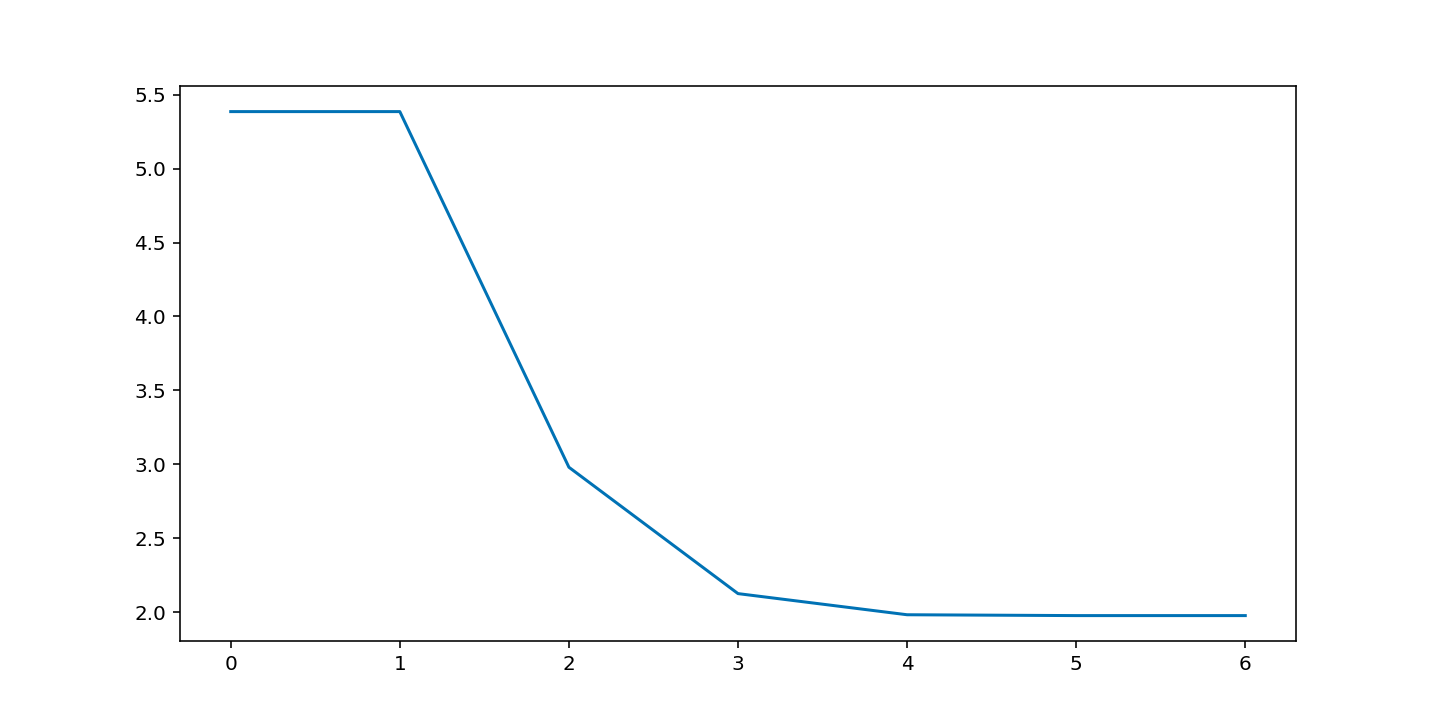

In [14]:
# Reactive Functions
reactive_plot = pn.bind(var_plot, variable)

pn.panel(reactive_plot, sizing_mode="scale_both").servable()

In [15]:
variables = pn.widgets.CheckBoxGroup(
    name="Variables", value=['z',], options=list(df.columns)
)
variables.servable(area="sidebar")

CheckBoxGroup(name='Variables', options=['z', 'x', 'con1', ...], sizing_mode='stretch_width', value=['z'])

In [ ]:
def vars_plot(variables=["z",]):
    fig = Figure(figsize=(10, 5))
    ax = fig.add_subplot()
    for variable in variables:
        df[variable].plot(ax=ax, c=primary_color)
    return fig

In [ ]:
# Reactive Functions
reactive_plots = pn.bind(vars_plot, variables)

pn.panel(reactive_plots, sizing_mode="scale_both").servable()